In [152]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime
import os
import gmaps
import seaborn as sns
import re

# Import API key from a file that is ignored by Git (.gitignore file) so the key isn't exposed to the public
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

## Store County Health Rankings Excel file results into DataFrame

* Load the excel file imported from https://www.countyhealthrankings.org/app/texas/2019/measure/outcomes/144/description?sort=desc-2

In [2]:
path = "data/2019 County Health Rankings Texas Data - v1_0.xls"

# Get the available sheets in the excel file and put into a list
sheets = pd.ExcelFile(path).sheet_names
print(sheets)

['Introduction', 'Outcomes & Factors Rankings', 'Outcomes & Factors SubRankings', 'Ranked Measure Data', 'Additional Measure Data', 'Ranked Measure Sources & Years', 'Addtl Measure Sources & Years']


## Read in the Ranked Measure Data sheet eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns
* Create a list of only wanted columns to be used for the usecols argument
* Set county to be the index
* Eliminate any row without a county name

In [3]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
rmd = pd.read_excel(path, header=[1], sheet_name=sheets[3])

# View the columns and decide what we don't want
[print(col) for col in rmd.columns] 

FIPS
State
County
Years of Potential Life Lost Rate
95% CI - Low
95% CI - High
Z-Score
YPLL Rate (Black)
YPLL Rate (Hispanic)
YPLL Rate (White)
% Fair/Poor
95% CI - Low.1
95% CI - High.1
Z-Score.1
Physically Unhealthy Days
95% CI - Low.2
95% CI - High.2
Z-Score.2
Mentally Unhealthy Days
95% CI - Low.3
95% CI - High.3
Z-Score.3
Unreliable
% LBW
95% CI - Low.4
95% CI - High.4
Z-Score.4
% LBW (Black)
% LBW (Hispanic)
% LBW (White)
% Smokers
95% CI - Low.5
95% CI - High.5
Z-Score.5
% Obese
95% CI - Low.6
95% CI - High.6
Z-Score.6
Food Environment Index
Z-Score.7
% Physically Inactive
95% CI - Low.7
95% CI - High.7
Z-Score.8
% With Access
Z-Score.9
% Excessive Drinking
95% CI - Low.8
95% CI - High.8
Z-Score.10
# Alcohol-Impaired Driving Deaths
# Driving Deaths
% Alcohol-Impaired
95% CI - Low.9
95% CI - High.9
Z-Score.11
# Chlamydia Cases
Chlamydia Rate
Z-Score.12
Teen Birth Rate
95% CI - Low.10
95% CI - High.10
Z-Score.13
Teen Birth Rate (Black)
Teen Birth Rate (Hispanic)
Teen Birth Rate (W

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [4]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|FIPS|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in rmd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
rmd_df = pd.read_excel(path, header=[1], sheet_name=sheets[3],usecols=cols,index_col=0)

# Drop any row that has Nan as an index value
rmd_df = rmd_df.loc[rmd_df.index.dropna()]
print(f'shape of rmd_df: {rmd_df.shape}')
#rmd_df.head(1)

shape of rmd_df: (254, 85)


## Read in the Additional Measure Data sheet eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns
* Create a list of only wanted columns to be used for the usecols argument
* Set county to be the index
* Eliminate any row without a county name

In [5]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
amd = pd.read_excel(path, header=[1], sheet_name=sheets[4])

# View the columns and decide what we don't want
[print(col) for col in amd.columns] 

FIPS
State
County
Life Expectancy
95% CI - Low
95% CI - High
Life Expectancy (Black)
Life Expectancy (Hispanic)
Life Expectancy (White)
# Deaths
Age-Adjusted Mortality
95% CI - Low.1
95% CI - High.1
Age-Adjusted Mortality (Black)
Age-Adjusted Mortality (Hispanic)
Age-Adjusted Mortality (White)
# Deaths.1
Child Mortality Rate
95% CI - Low.2
95% CI - High.2
Child Mortality Rate (Black)
Child Mortality Rate (Hispanic)
Child Mortality Rate (White)
# Deaths.2
Infant Mortality Rate
95% CI - Low.3
95% CI - High.3
Infant Mortality Rate (Black)
Infant Mortality Rate (Hispanic)
Infant Mortality Rate (White)
% Frequent Physical Distress
95% CI - Low.4
95% CI - High.4
% Frequent Mental Distress
95% CI - Low.5
95% CI - High.5
% Diabetic
95% CI - Low.6
95% CI - High.6
# HIV Cases
HIV Prevalence Rate
# Food Insecure
% Food Insecure
# Limited Access
% Limited Access
# Drug Overdose Deaths
Drug Overdose Mortality Rate
# Motor Vehicle Deaths
MV Mortality Rate
95% CI - Low.7
95% CI - High.7
% Insufficien

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|FIPS|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in amd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
amd_df = pd.read_excel(path, header=[1], sheet_name=sheets[4],usecols=cols,index_col=0)

# Drop any row that has Nan as an index value
amd_df = amd_df.loc[amd_df.index.dropna()]
print(f'shape of amd_df: {amd_df.shape}')
#amd_df.head(1)

shape of amd_df: (254, 74)


In [7]:
# Merge the rmd and amd dataframes using inner join on County column (index)
merged_df = pd.merge(rmd_df,amd_df, how='inner', on='County')
print(f'shape of merged_df: {merged_df.shape}')
#merged_df.head(1)

shape of merged_df: (254, 159)


In [16]:
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
[print(col) for col in merged_df.columns if re.match(regex2,col) is not None] 

# Uninsured_x
% Uninsured_x
Population_x
# Uninsured_y
% Uninsured_y
Population_y


[None, None, None, None, None, None]

In [17]:
# Drop the duplicate _y columns
regex3 = '.*_y$'
merged_df.drop([col for col in merged_df.columns if re.match(regex3,col) is not None],axis=1, inplace=True)
print(merged_df.shape)

(254, 156)


## Import a County Status excel file (Maps counties to either 'Rural' or 'Urban')

In [19]:
path2 = 'data/county_status.xlsx'

# Get the available sheets in the excel file and put into a list
sheets2 = pd.ExcelFile(path2).sheet_names
print(sheets2)

['RVU']


In [50]:

# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
cs = pd.read_excel(path2,usecols=['County','Status'],index_col=0)
cs.index

# Drop any row that has Nan as an index value
cs = cs.loc[cs.index.dropna()]
print(f'shape of cs: {cs.shape}')



shape of cs: (258, 1)


In [51]:
# Check that all counties are in both lists and spelled the same 
print(f'merged_df county:{[county for county in merged_df.index if county not in cs.index]} not found in cs.index')
print(f'cs county:{[county for county in cs.index if county not in merged_df.index]} not found in merged_df.index')

merged_df county:['DeWitt'] not found in cs.index
cs county:['De Witt', ' ', ' ', ' ', ' '] not found in merged_df.index


In [57]:
# Drop the columns with spaces as an index value
cs.loc[cs.index != ' ']
print(f'shape of cs: {cs.shape}')

shape of cs: (254, 1)


In [61]:
# Rename the cs index 'De Witt' to 'DeWitt'
cs = cs.rename(index={'De Witt': 'DeWitt'})
print(cs[cs.index == 'DeWitt'])

       Status
County       
DeWitt  Rural


In [60]:
print(cs[cs.index == 'DeWitt'])


       Status
County       
DeWitt  Rural


In [160]:
all_df = pd.merge(cs,merged_df, how='inner', on='County')
print(final_merged_df.shape)

(254, 157)


In [161]:
multi_df = all_df.set_index('Status', append=True)
multi_df.head()

,,Years of Potential Life Lost Rate,YPLL Rate (Black),YPLL Rate (Hispanic),YPLL Rate (White),% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% LBW (Black),% LBW (Hispanic),...,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,% Female,# Rural,% Rural
County,Status,,,,,,,,,,,,,,,,,,,,,
Anderson,Rural,10272.949118,12962.159784,10880.315229,9971.540573,19.529585,3.926130,3.642847,7.249879,11.444921,4.428424,...,0.143745,10287,17.815763,34140,59.126098,1488,2.715874,39.067560,39204,67.063533
Andrews,Rural,7952.973251,NaN,7774.144329,8202.896838,17.307710,3.302811,3.198057,6.313835,NaN,5.912040,...,0.022571,9958,56.190046,7131,40.238122,1184,7.408334,49.035098,2440,16.502097
Angelina,Rural,9018.498513,14014.161619,4450.704830,9293.129659,23.207340,4.223947,4.070546,8.769194,14.041605,8.052833,...,0.063778,19475,22.179830,53264,60.661694,3650,4.471560,51.333068,37383,43.082366
Aransas,Urban,9315.870361,NaN,6088.571549,11277.610901,19.517678,3.859044,3.743100,9.686610,NaN,8.623088,...,0.082121,7072,27.655248,17177,67.171125,375,1.588916,50.527921,6313,27.260558
Archer,Urban,9446.113949,NaN,NaN,NaN,13.248280,3.194982,3.405329,8.349146,NaN,NaN,...,0.034056,765,8.684300,7754,88.023612,69,0.823881,50.448405,8057,88.988292


In [162]:
multi_df = multi_df.reorder_levels([1,0]).sort_index()
#final_merged_df = final_merged_df.reindex()
multi_df.head()

Years of Potential Life Lost Rate  YPLL Rate (Black)  \
Status County                                                           
Rural  Anderson                       10272.949118       12962.159784   
       Andrews                         7952.973251                NaN   
       Angelina                        9018.498513       14014.161619   
       Bailey                          8326.013329                NaN   
       Baylor                         10617.916861                NaN   

                 YPLL Rate (Hispanic)  YPLL Rate (White)  % Fair/Poor  \
Status County                                                           
Rural  Anderson          10880.315229        9971.540573    19.529585   
       Andrews            7774.144329        8202.896838    17.307710   
       Angelina           4450.704830        9293.129659    23.207340   
       Bailey             7370.998705       12900.396823    27.307111   
       Baylor                     NaN                NaN    16.437425   

                 Physically Unhealthy Days  Mentally Unhealthy Days  \
Status County                                                         
Rural  Anderson                   3.926130                 3.642847   
       Andrews                    3.302811                 3.198057   
       Angelina                   4.223947                 4.070546   
       Bailey                     4.516392                 3.968838   
       Baylor                     3.682539                 3.731401   

                     % LBW  % LBW (Black)  % LBW (Hispanic)  ...  \
Status County                                                ...   
Rural  Anderson   7.249879      11.444921          4.428424  ...   
       Andrews    6.313835            NaN          5.912040  ...   
       Angelina   8.769194      14.041605          8.052833  ...   
       Bailey     7.198228            NaN          7.973422  ...   
       Baylor    10.408922            NaN               NaN  ...   

                 % Native Hawaiian/Other Pacific Islander  # Hispanic  \
Status County                                                           
Rural  Anderson                                  0.143745       10287   
       Andrews                                   0.022571        9958   
       Angelina                                  0.063778       19475   
       Bailey                                    0.127173        4550   
       Baylor                                    0.083775         471   

                 % Hispanic  # Non-Hispanic White  % Non-Hispanic White  \
Status County                                                             
Rural  Anderson   17.815763                 34140             59.126098   
       Andrews    56.190046                  7131             40.238122   
       Angelina   22.179830                 53264             60.661694   
       Bailey     64.292779                  2328             32.895295   
       Baylor     13.152751                  2937             82.016197   

                 # Not Proficient in English  % Not Proficient in English  \
Status County                                                               
Rural  Anderson                         1488                     2.715874   
       Andrews                          1184                     7.408334   
       Angelina                         3650                     4.471560   
       Bailey                           1124                    17.105463   
       Baylor                              0                     0.000000   

                  % Female  # Rural     % Rural  
Status County                                    
Rural  Anderson  39.067560    39204   67.063533  
       Andrews   49.035098     2440   16.502097  
       Angelina  51.333068    37383   43.082366  
       Bailey    49.780981     2060   28.750872  
       Baylor    50.879643     3726  100.000000  

[5 rows x 156 columns]

In [163]:
#idx = pd.IndexSlice
#rural_df = final_merged_df.loc[idx['Rural',:],:]
rural_df = multi_df.loc['Rural']
print(rural_df.shape)

(172, 156)


In [164]:
#urban_df = final_merged_df.loc[idx['Urban',:],:]
urban_df = multi_df.loc['Urban']
print(urban_df.shape)

(82, 156)


In [165]:
urban_df.head()

,Years of Potential Life Lost Rate,YPLL Rate (Black),YPLL Rate (Hispanic),YPLL Rate (White),% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% LBW (Black),% LBW (Hispanic),...,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,% Female,# Rural,% Rural
County,,,,,,,,,,,,,,,,,,,,,
Aransas,9315.870361,NaN,6088.571549,11277.610901,19.517678,3.859044,3.743100,9.686610,NaN,8.623088,...,0.082121,7072,27.655248,17177,67.171125,375,1.588916,50.527921,6313,27.260558
Archer,9446.113949,NaN,NaN,NaN,13.248280,3.194982,3.405329,8.349146,NaN,NaN,...,0.034056,765,8.684300,7754,88.023612,69,0.823881,50.448405,8057,88.988292
Armstrong,NaN,NaN,NaN,NaN,11.754162,2.960202,3.277977,8.108108,NaN,NaN,...,0.000000,141,7.503991,1684,89.622139,11,0.602410,51.250665,1901,100.000000
Atascosa,7645.013715,NaN,7306.194334,8273.952313,22.392609,3.950304,3.545031,8.163698,NaN,8.549383,...,0.118413,31578,64.469896,16349,33.378249,1659,3.712074,50.186807,27266,60.711184
Austin,6980.706882,10025.025387,4244.328056,7927.523024,16.912532,3.428932,3.567402,7.929883,14.403292,7.049892,...,0.040287,8083,27.136910,18469,62.005640,1415,5.144145,50.399517,18853,66.344090


In [166]:
corr = multi_df.corr()

In [150]:
corr.to_csv('Corr.csv')

In [167]:
multi_df.to_csv('multi_df.csv')

In [168]:
corr_spear = multi_df.corr(method='spearman')

In [169]:
corr_spear.to_csv('Corr_spear.csv')

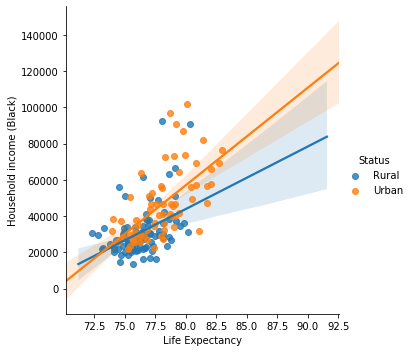

In [171]:
sns.lmplot(x="Life Expectancy", y="Household income (Black)", data=all_df, hue="Status")